# Data load


In [ ]:
import pandas as pd
import numpy as np
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
from gensim.models import Word2Vec
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, LSTM, Embedding, Input, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

wnl=WordNetLemmatizer()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# data load by kaggle API
"""from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d algord/fake-news
!unzip fake-news.zip
data_path='FakeNewsNet.csv'"""

# data load by drive
data_path='/content/drive/MyDrive/FakeNewsNet.csv'
data=pd.read_csv(data_path)

In [ ]:
data

,title,news_url,source_domain,tweet_num,real
0,Kandi Burruss Explodes Over Rape Accusation on...,http://toofab.com/2017/05/08/real-housewives-a...,toofab.com,42,1
1,People's Choice Awards 2018: The best red carp...,https://www.today.com/style/see-people-s-choic...,www.today.com,0,1
2,Sophia Bush Sends Sweet Birthday Message to 'O...,https://www.etonline.com/news/220806_sophia_bu...,www.etonline.com,63,1
3,Colombian singer Maluma sparks rumours of inap...,https://www.dailymail.co.uk/news/article-33655...,www.dailymail.co.uk,20,1
4,Gossip Girl 10 Years Later: How Upper East Sid...,https://www.zerchoo.com/entertainment/gossip-g...,www.zerchoo.com,38,1
...,...,...,...,...,...
23191,Pippa Middleton wedding: In case you missed it...,https://www.express.co.uk/news/royal/807049/pi...,www.express.co.uk,52,1
23192,Zayn Malik & Gigi Hadid’s Shocking Split: Why ...,hollywoodlife.com/2018/03/13/zayn-malik-gigi-h...,hollywoodlife.com,7,0
23193,Jessica Chastain Recalls the Moment Her Mother...,http://www.justjared.com/2018/01/17/jessica-ch...,www.justjared.com,26,1
23194,"Tristan Thompson Feels ""Dumped"" After Khloé Ka...",www.intouchweekly.com/posts/tristan-thompson-f...,www.intouchweekly.com,24,0


#Data preprocessing


In [ ]:
data.head()

,title,news_url,source_domain,tweet_num,real
0,Kandi Burruss Explodes Over Rape Accusation on...,http://toofab.com/2017/05/08/real-housewives-a...,toofab.com,42,1
1,People's Choice Awards 2018: The best red carp...,https://www.today.com/style/see-people-s-choic...,www.today.com,0,1
2,Sophia Bush Sends Sweet Birthday Message to 'O...,https://www.etonline.com/news/220806_sophia_bu...,www.etonline.com,63,1
3,Colombian singer Maluma sparks rumours of inap...,https://www.dailymail.co.uk/news/article-33655...,www.dailymail.co.uk,20,1
4,Gossip Girl 10 Years Later: How Upper East Sid...,https://www.zerchoo.com/entertainment/gossip-g...,www.zerchoo.com,38,1


In [ ]:
# duplicate title

print(data['title'].duplicated().sum())

data.drop_duplicates(subset=['title'], inplace=True)

1472


In [ ]:
# missing value
print(data.isna().sum())

data.dropna(inplace=True)

title              0
news_url         327
source_domain    327
tweet_num          0
real               0
dtype: int64


real
1    16401
0     4996
Name: count, dtype: int64


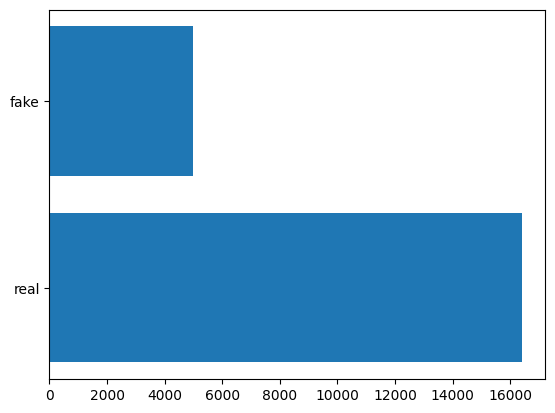

In [ ]:
# unbalanced data
print(data['real'].value_counts())

plt.barh(['real', 'fake'], data['real'].value_counts())
plt.show()

In [ ]:
# preprocess
def preprocess(sent):
  for char in "!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~":
    sent=sent.replace(char,'')

  words=sent.split()

  for i in range(len(words)):
    words[i]=words[i].lower()
    words[i]=wnl.lemmatize(words[i])

  new_words=[]
  for word in words:
    if word not in stop_words:
      new_words.append(word)

  return new_words

# extract source
def extract_source(source_domain):
  if source_domain.count('.')>1:
    return source_domain.split('.')[1]
  else:
    return source_domain.split('.')[0]

data['preprocessed_title']=data['title'].apply(preprocess)
data['source_domain']=data['source_domain'].apply(extract_source)

In [ ]:
data.head()

,title,news_url,source_domain,tweet_num,real,preprocessed_title
0,Kandi Burruss Explodes Over Rape Accusation on...,http://toofab.com/2017/05/08/real-housewives-a...,toofab,42,1,"[kandi, burruss, explodes, rape, accusation, r..."
1,People's Choice Awards 2018: The best red carp...,https://www.today.com/style/see-people-s-choic...,today,0,1,"[people, choice, award, 2018, best, red, carpe..."
2,Sophia Bush Sends Sweet Birthday Message to 'O...,https://www.etonline.com/news/220806_sophia_bu...,etonline,63,1,"[sophia, bush, sends, sweet, birthday, message..."
3,Colombian singer Maluma sparks rumours of inap...,https://www.dailymail.co.uk/news/article-33655...,dailymail,20,1,"[colombian, singer, maluma, spark, rumour, ina..."
4,Gossip Girl 10 Years Later: How Upper East Sid...,https://www.zerchoo.com/entertainment/gossip-g...,zerchoo,38,1,"[gossip, girl, 10, year, later, upper, east, s..."


In [ ]:
data['source_domain'].value_counts()

,count
source_domain,
people,1634
dailymail,918
usmagazine,659
etonline,634
longroom,562
...,...
trueamericans,1
archynety,1
wtnh,1


In [ ]:
# split train and test data
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

In [ ]:
# class weights
def compute_class_weights(y):
  classes=[0, 1]
  counts=[y.value_counts()[0], y.value_counts()[1]]
  total=sum(counts)
  class_weights={}

  for i in range(len(classes)):
    class_weights[classes[i]]=total/(2*counts[i])

  return class_weights

class_weights=compute_class_weights(train_data['real'])
print(class_weights)

{0: 2.132693745327685, 1: 0.6531211843711844}


In [ ]:
# title embedding
train_titles=train_data['preprocessed_title']
test_titles=test_data['preprocessed_title']
w2v=Word2Vec(sentences=train_titles, vector_size=100, min_count=1, window=3)

tokenizer=Tokenizer()
tokenizer.fit_on_texts(train_titles)
train_sequences=tokenizer.texts_to_sequences(train_titles)
test_sequences=tokenizer.texts_to_sequences(test_titles)
max_len=max([len(seq) for seq in train_sequences])

word_num=len(tokenizer.word_index)+1
embedding_weights=np.zeros((word_num, 100))

word_idx=list(tokenizer.word_index)
for i in range(len(word_idx)):
  if word_idx[i] in w2v.wv:
    embedding_weights[i+1]=w2v.wv[word_idx[i]]

train_sequences_pad=pad_sequences(train_sequences, maxlen=max_len, padding='post')
test_sequences_pad=pad_sequences(test_sequences, maxlen=max_len, padding='post')

# source_domain encoding
ohe=OneHotEncoder(handle_unknown='ignore')

train_encoded_source=ohe.fit_transform(train_data[['source_domain']]).toarray()
test_encoded_source=ohe.transform(test_data[['source_domain']]).toarray()

count=np.sum(np.all(test_encoded_source==np.zeros(1878), axis=1))
print('the number of unknown sources:', count)

the number of unknown sources: 263


# Model Impletation with LSTM





## 'title'

In [ ]:
# modeling

train_target=np.array(train_data['real'])
test_target=np.array(test_data['real'])

# split train and validation data
Train_sequences_pad, Val_sequences_pad, Train_target, Val_target=train_test_split(train_sequences_pad, train_target, test_size=0.2, random_state=42)

model=Sequential()
model.add(Embedding(input_dim=word_num, output_dim=100, input_length=max_len, weights=[embedding_weights], trainable=False))
model.add(LSTM(32))
model.add(Dense(units=1, activation='sigmoid'))
model.build(input_shape=(None, 35))
model.summary()

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
early_stopping=EarlyStopping(patience=5, restore_best_weights=True)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)              │ (None, 35, 100)             │       1,822,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_6 (LSTM)                        │ (None, 32)                  │          17,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,839,757 (7.02 MB)

 Trainable params: 17,057 (66.63 KB)

 Non-trainable params: 1,822,700 (6.95 MB)

In [ ]:
history=model.fit(Train_sequences_pad, Train_target, epochs=20, batch_size=32, class_weight=class_weights, callbacks=[early_stopping], validation_data=[Val_sequences_pad, Val_target])

Epoch 1/20
428/428 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.6741 - loss: 0.6768 - val_accuracy: 0.7687 - val_loss: 0.5805
Epoch 2/20
428/428 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.7084 - loss: 0.6263 - val_accuracy: 0.6384 - val_loss: 0.6843
Epoch 3/20
428/428 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.7090 - loss: 0.6176 - val_accuracy: 0.7693 - val_loss: 0.5837
Epoch 4/20
428/428 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.7157 - loss: 0.6093 - val_accuracy: 0.7681 - val_loss: 0.5698
Epoch 5/20
428/428 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - accuracy: 0.7098 - loss: 0.6102 - val_accuracy: 0.7734 - val_loss: 0.5752
Epoch 6/20
428/428 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.7177 - loss: 0.6100 - val_accuracy: 0.7748 - val_loss: 0.5573
Epoch 7/20
428/428 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.7210 - loss: 0.6050 - val_accuracy: 0.7900 - val_loss: 0.5766
Epoch 8/20
428/428 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.7284 - loss: 0.6099 - val_

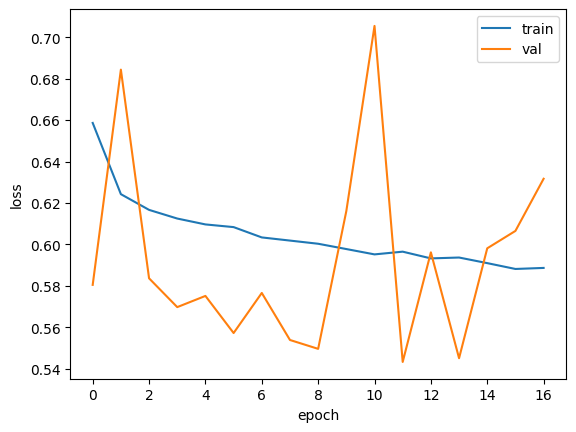

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

In [ ]:
# model evaluation
threshold=0.5
test_pred_prob=model.predict(test_sequences_pad)
test_pred=np.zeros(test_target.shape)
for i in range(test_pred_prob.shape[0]):
  if test_pred_prob[i]>=threshold:
    test_pred[i]=1

print(classification_report(test_target, test_pred))

134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
              precision    recall  f1-score   support

           0       0.48      0.55      0.52       983
           1       0.86      0.82      0.84      3297

    accuracy                           0.76      4280
   macro avg       0.67      0.69      0.68      4280
weighted avg       0.77      0.76      0.77      4280



## 'title' + 'source'

In [ ]:
# modeling

# split train and validation data
train_x=np.concatenate((train_sequences_pad, train_encoded_source), axis=1)
Train_x, Val_x, Train_target, Val_target=train_test_split(train_x, train_target, test_size=0.2, random_state=42)
Train_sequences_pad=Train_x[:, :max_len]
Val_sequences_pad=Val_x[:, :max_len]
Train_encoded_source=Train_x[:, max_len:]
Val_encoded_source=Val_x[:, max_len:]

# title model
title_input=Input(shape=(max_len,), name="title_input")
embedding_layer=Embedding(input_dim=word_num, output_dim=100, input_length=max_len, weights=[embedding_weights], trainable=False)(title_input)
title_output=LSTM(32)(embedding_layer)

# source model
source_input=Input(shape=(Train_encoded_source.shape[1],), name="source_input")
source_output=Dense(units=16, activation='relu')(source_input)

# final model
inputs=Concatenate()([title_output, source_output])
output=Dense(units=1, activation='sigmoid')(inputs)
model2=Model(inputs=[title_input, source_input], outputs=output)
model2.summary()

model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
early_stopping=EarlyStopping(patience=5, restore_best_weights=True)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ title_input (InputLayer)  │ (None, 35)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_7 (Embedding)   │ (None, 35, 100)        │      1,822,700 │ title_input[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ source_input (InputLayer) │ (None, 1878)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_7 (LSTM)             │ (None, 32)             │         17,024 │ embedding_7[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_10 (Dense)          │ (None, 16)             │         30,064 │ source_input[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_3             │ (None, 48)             │              0 │ lstm_7[0][0],          │
│ (Concatenate)             │                        │                │ dense_10[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_11 (Dense)          │ (None, 1)              │             49 │ concatenate_3[0][0]    │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,869,837 (7.13 MB)

 Trainable params: 47,137 (184.13 KB)

 Non-trainable params: 1,822,700 (6.95 MB)

In [ ]:
history=model2.fit([Train_sequences_pad, Train_encoded_source], Train_target, epochs=20, batch_size=32, class_weight=class_weights, callbacks=[early_stopping], validation_data=([Val_sequences_pad, Val_encoded_source], Val_target))

Epoch 1/20
428/428 ━━━━━━━━━━━━━━━━━━━━ 13s 22ms/step - accuracy: 0.6475 - loss: 0.6546 - val_accuracy: 0.7821 - val_loss: 0.5388
Epoch 2/20
428/428 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.7795 - loss: 0.5245 - val_accuracy: 0.8189 - val_loss: 0.4695
Epoch 3/20
428/428 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.8111 - loss: 0.4725 - val_accuracy: 0.7360 - val_loss: 0.5389
Epoch 4/20
428/428 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.8160 - loss: 0.4467 - val_accuracy: 0.8140 - val_loss: 0.4367
Epoch 5/20
428/428 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.8318 - loss: 0.4220 - val_accuracy: 0.7631 - val_loss: 0.5038
Epoch 6/20
428/428 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.8196 - loss: 0.4242 - val_accuracy: 0.7544 - val_loss: 0.5133
Epoch 7/20
428/428 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.8268 - loss: 0.4188 - val_accuracy: 0.7485 - val_loss: 0.5128
Epoch 8/20
428/428 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.8219 - loss: 0.4161 - val_a

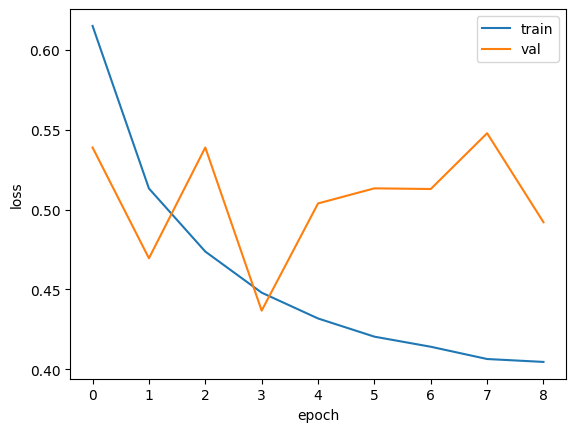

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

In [ ]:
# model evaluation
threshold=0.5
test_pred_prob=model2.predict([test_sequences_pad, test_encoded_source])
test_pred=np.zeros(test_target.shape)
for i in range(test_pred_prob.shape[0]):
  if test_pred_prob[i]>=threshold:
    test_pred[i]=1

print(classification_report(test_target, test_pred))

134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
              precision    recall  f1-score   support

           0       0.64      0.63      0.63       983
           1       0.89      0.89      0.89      3297

    accuracy                           0.83      4280
   macro avg       0.76      0.76      0.76      4280
weighted avg       0.83      0.83      0.83      4280



In [ ]:
# model saving

model2.save('/content/drive/MyDrive/my_model.h5')